# Определение скважины для разработки

# 1. Загрузка и подготовка данных

## 1.2. Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

from re import sub
from urllib.parse import urlencode
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

In [3]:
# глобальные константные переменные

LINK0 = "https://yadi.sk/d/_HDU8w3Gmc3rQw"
LINK1 = "https://yadi.sk/d/T6qryrMpIw6-dQ"
LINK2 = "https://yadi.sk/d/ptUevke4gA06xA"

RANDOM = 12345
PRICE = 450000
BUDGET = 10**10
WELLS = 200

##  1.3. Функции

In [4]:
def get_url(link):
    """
    Получение адреса для скачивания с Яндекс.Диск
    link - ссылка на Яндекс.Диск
    """
    print("Run", link)
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=link))
    response = requests.get(final_url)
    url = response.json()['href']
    return url

In [5]:
def split_data(features, target, validate=True, test_size=0.25):
    """
    Функция разбивает данные на 2 или 3 выборки: обучающую, 
    валидационную (опционально) и тестовую
    """
    features_set = ()
    target_set = ()
    
    if validate:
        features_train, features_valid, target_train, target_valid = train_test_split(
            features, target, test_size=0.4, random_state=RANDOM
        )

        features_valid, features_test, target_valid, target_test = train_test_split(
            features_valid, target_valid, test_size=0.5, random_state=RANDOM
        )
        
        features_set = (features_train, features_valid, features_test)
        target_set = (target_train, target_valid, target_test)
        
    else:
        # только обучающая и тестовая
        features_train, features_test, target_train, target_test = train_test_split(
            features, target, test_size=test_size, random_state=RANDOM
        )
                
        features_set = (features_train, features_test)
        target_set = (target_train, target_test)

    return {'features': features_set, 'target': target_set}

In [6]:
def encoding(df, x):
    """
    Функция для кодирования строковых признаков. Возвращает DataFrame
    
    df - датафрейм
    x  - список признаков
    """
    
    if type(x).__name__ != 'list':
        raise Exception("Error: x must be 'list' type")
        
    encoder = OrdinalEncoder()
    df_ordinal = pd.DataFrame(encoder.fit_transform(df[x]), columns=x)
    df[x] = df_ordinal[x]
    
    return df

In [7]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

In [8]:
# разделение на выборки

def split_geo(df):
    target = df[['product']]
    features = df.drop(['product'], axis=1)
    
    # бьем согласно условию задачи 75:25
    split_result = split_data(features, target, validate=False, test_size=0.25)

    X_train, X_test = split_result['features']
    y_train, y_test = split_result['target']
    
    return (X_train, X_test, y_train, y_test)

In [9]:
def grid_search(X_train, y_train):
    parameters = {'fit_intercept':[True,False],
                  'normalize':[True,False],
                  'copy_X':[True, False]}

    model = LinearRegression()
    grid = GridSearchCV(model, parameters, cv=5, scoring=make_scorer(rmse))
    grid.fit(X_train, y_train)
    
    return (grid.best_estimator_, grid.best_score_)

In [10]:
def learn(df):
    X_train, X_test, y_train, y_test = split_geo(df)
    m = LinearRegression()
    validate_results = cross_validate(m, X_train, y_train, cv=5, scoring=make_scorer(rmse), 
                                      return_estimator=True)
    reg = validate_results['estimator'][0]
    y_pred = reg.predict(X_test)
    target = y_test.reset_index(drop=True)
    predictions = pd.DataFrame(y_pred)[0]
    
    
    rmse_train = validate_results['test_score'].mean()
    rmse_test = rmse(y_test, y_pred) 
    
    ##########################

    target_mean = target.mean()[0]
    predictions_mean = predictions.mean()
    
    print('\n', df.name, '\n')
    print('RMSE: {}'.format(rmse_test))
    # print('mean true value: {}'.format(target_mean))
    print('mean product: {}'.format(predictions_mean))
    
    return {'predictions': predictions, 'target': target, 
            'name': df.name, 'rmse': rmse_test, 'mean': predictions_mean}

In [11]:
def get_profit_1(target, predictions):
    predictions_sorted = predictions.sort_values(ascending=False)
    selected_points = target[predictions_sorted.index][:200]
    product = selected_points.sum()
    revenue = product * PRICE
    return revenue - BUDGET

## 1.4. Данные (EDA)

In [12]:
# загрузка данных
geo_0 = pd.read_csv(get_url(LINK0))
geo_1 = pd.read_csv(get_url(LINK1))
geo_2 = pd.read_csv(get_url(LINK2))

geo_0.name = 'GEO-0'
geo_1.name = 'GEO-1'
geo_2.name = 'GEO-2'

Run https://yadi.sk/d/_HDU8w3Gmc3rQw
Run https://yadi.sk/d/T6qryrMpIw6-dQ
Run https://yadi.sk/d/ptUevke4gA06xA


Посмотрим на данные и их описание.

In [13]:
geo_0.sample(5)

,id,f0,f1,f2,product
57272,zZAjp,0.334153,0.819065,7.655791,57.267090
64253,Ckf22,1.171774,-0.490879,4.624204,74.335687
33503,KrzAf,-0.442493,0.889708,4.672672,35.858999
70641,9xBDD,1.858801,0.235313,2.135992,62.290094
44904,SnoaT,1.751104,0.046298,0.513333,164.057417


In [14]:
geo_1.sample(5)

,id,f0,f1,f2,product
69451,Mb5B8,0.366897,0.569397,1.004396,30.132364
70486,T4jwW,10.919559,1.027353,5.000734,134.766305
86602,G2G4X,-4.647780,-13.306339,2.001271,57.085625
63321,2dXfd,-5.474659,-5.648201,3.994501,110.992147
15109,WLlev,-10.738519,-1.996062,-0.001862,3.179103


In [15]:
geo_2.sample(5)

,id,f0,f1,f2,product
72113,GX7iT,-0.807833,1.897460,6.676599,185.646554
3443,JoDTI,-0.664739,-1.393907,0.511445,63.468737
75678,SePJu,1.447720,0.495721,3.478243,61.858737
43782,5ndAK,1.985892,1.364011,6.198751,156.192087
58313,HQq5l,4.207228,2.033439,7.388893,69.274751


In [16]:
for i, d in enumerate([geo_0, geo_1, geo_2]):
    print("\n==========================")
    print("  Information for geo-{}:".format(i))
    print("==========================\n")
    print(d.info())
    print()
#     print(d.describe())


  Information for geo-0:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


  Information for geo-1:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


  Information for geo-2:

<class 'pandas.core.frame.DataFrame'>
R

Посмотрим на распределение количественных признаков.

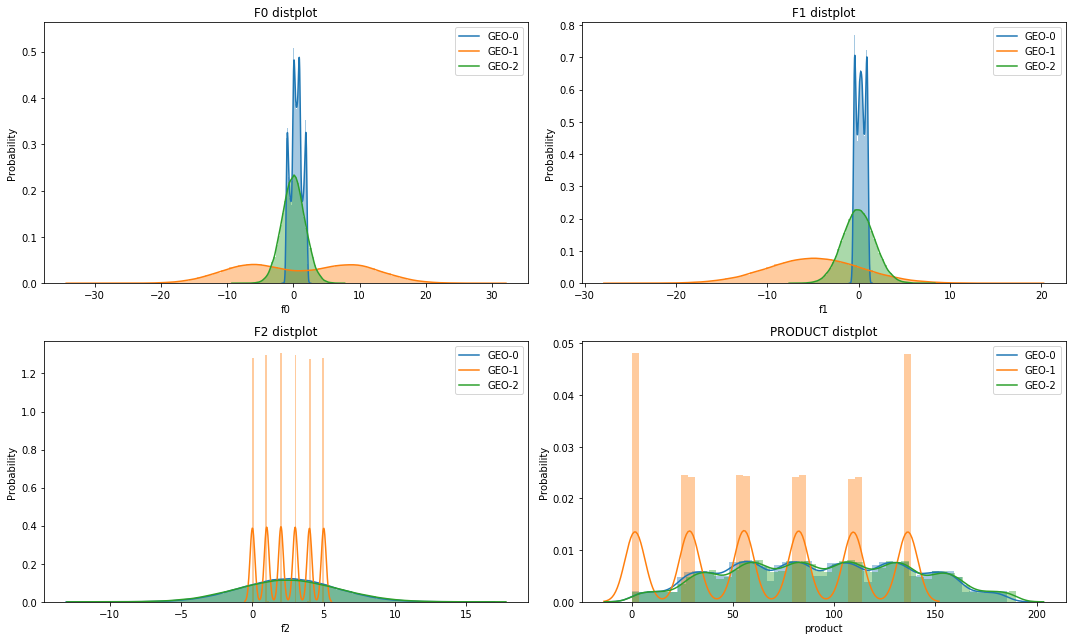

In [17]:
features = ['f0', 'f1', 'f2', 'product']
cols = 2
rows = len(features) // 2 + len(features) % 2
cols_id = []
rows_id = []

for i in range(rows):
    for j in range(cols):
        rows_id.append(i)
        cols_id.append(j)


fig, axes = plt.subplots(rows, cols, figsize=(15,9))
legend_list = [ d.name for d in [geo_0, geo_1, geo_2]]


for i,j,feature in zip(rows_id, cols_id, features):
    ax=axes[i][j]
 
    for data in [geo_0, geo_1, geo_2]:
        sns.distplot(data[feature], ax=ax);
        
    ax.title.set_text('{} distplot'.format(feature.upper()))
    ax.set_ylabel('Probability')
    ax.legend(legend_list)
fig.tight_layout()
plt.show() 

Видим, что одинаковые показатели качества продукта демонстрируют разное распределение на разных месторождениях. Посмотрим на матрицу корреляции.

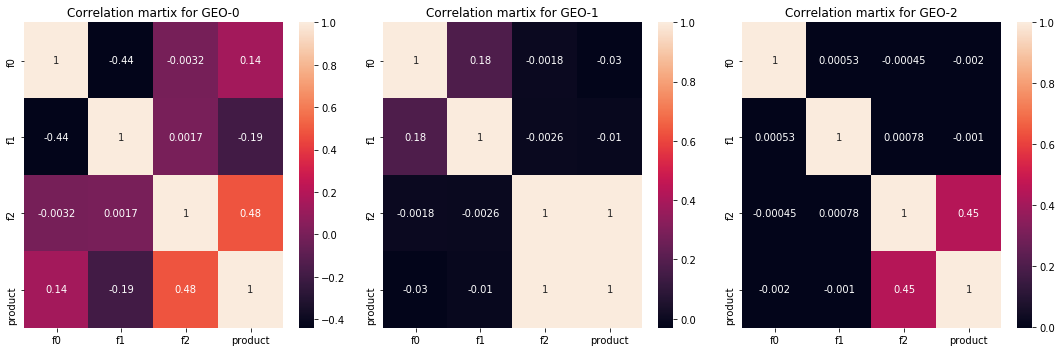

In [18]:
# матрицы корреляции
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, df in enumerate([geo_0, geo_1, geo_2]):
    ax=axes[i]
    sns.heatmap(df.corr(), annot=True, ax=ax);
    ax.title.set_text('Correlation martix for {}'.format(df.name.upper()))

fig.tight_layout()
plt.show()

Видим, что для всех районов признак _id_ не имеет никакой связи с целевым _product_. Удалим ненужные признаки - для всех районов *id*. Остальные признаки значимые согласно условию проекта.

In [19]:
geo_0.drop(['id'], axis=1, inplace=True)
geo_1.drop(['id'], axis=1, inplace=True)
geo_2.drop(['id'], axis=1, inplace=True)

In [20]:
geo_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


In [21]:
geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


In [22]:
geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


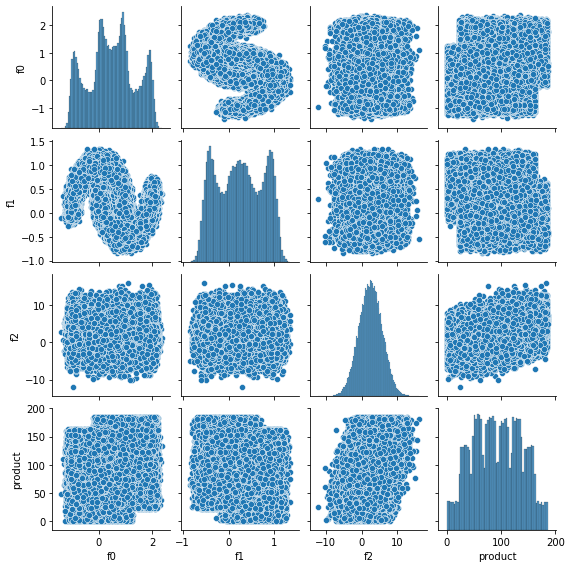

In [23]:
sns.pairplot(geo_0, height=2);

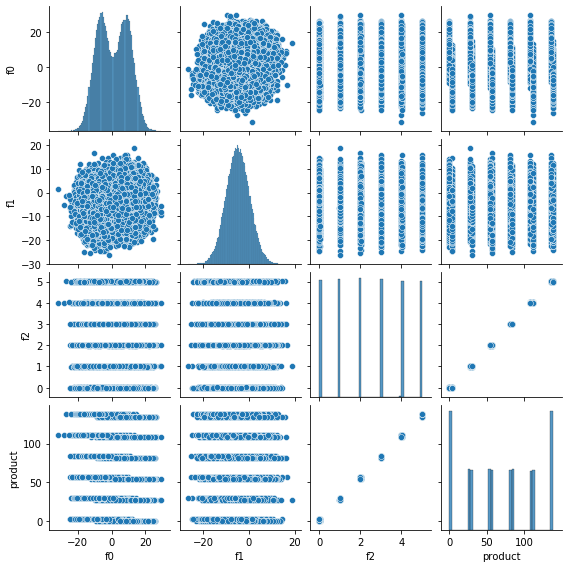

In [24]:
sns.pairplot(geo_1, height=2);

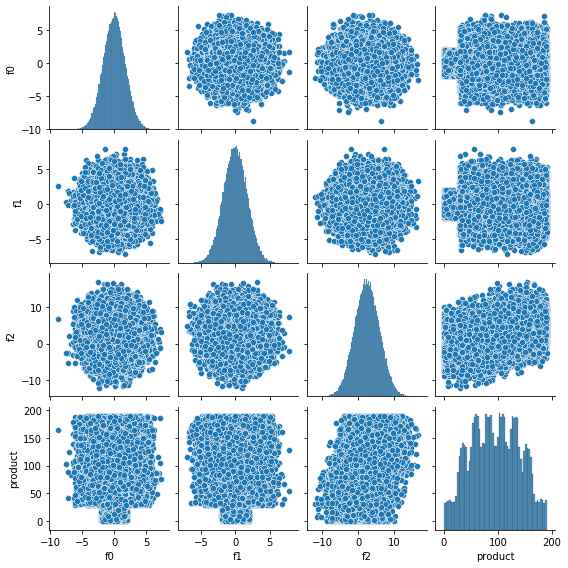

In [25]:
sns.pairplot(geo_2, height=2);

## 1.4. Вывод

* Для каждого из набора данные одинакового размера со схожей структурой, пропусков нет.
* Из тепловой карты матрицы корреляции видно, что признаки имеют слабую зависимость (прямую или обратную).

Требуется предсказывать непрерывную величину, соответственно будет использоваться алгоритм для задач регрессии - *Линейная регрессия*.

# 2. Обучение и проверка модели

## 2.2. Обучение и предсказание

In [26]:
learn_results = {}

for df in [geo_0, geo_1, geo_2]:
    learn_results[df.name] = learn(df)


 GEO-0 

RMSE: 37.5769749244808
mean product: 92.57546571524018

 GEO-1 

RMSE: 0.8930991545282705
mean product: 68.72500836283491

 GEO-2 

RMSE: 40.0298638610466
mean product: 94.94042066616547


## 2.3. Вывод

Для разных моделей (и районов соответственно) видим разные значения RMSE, однако и средние значения разные. Средние предсказаний меньше истинных и их разница изменяется в разных районах.

# 3. Подготовка к расчёту прибыли

Достаточный объем сырья для безубыточной разработки новой скважины равен:

***(Общий бюджет) / (Сумма за единицу продукта) / (Количество скважин)***

In [27]:
min_product = round(BUDGET / PRICE / WELLS, 2)
min_product

111.11

Получаем, что в среднем запас скважины должен быть ~111 тыс. баррелей. Из предсказаний модели и из фактических данных всех районов объем запасов меньше определенного минимального объема. Ближе всего к этому значению районы geo-0 и geo-2 по фактическим данным. Для geo-0 *прогноз* по запасам самый оптимистичный.

In [28]:
# получаем данные с предсказанными величинами для каждого региона
geo_0_res, geo_1_res, geo_2_res = [ learn_results[name] for name in ['GEO-0', 'GEO-1', 'GEO-2'] ]

# 4. Расчёт прибыли и рисков 

Применим технику Bootstrap c 1000 выборок по 500 и сохраним распределение прибыли для каждого района.

GEO-0
RMSE: 37.5769749244808
Mean product: 92.57546571524018
Mean revenue: 426715453.7610123
Interval:     (-98964117.1754137, 946843987.1643748)
Risk:         5.8999999999999995%

GEO-1
RMSE: 0.8930991545282705
Mean product: 68.72500836283491
Mean revenue: 518259493.69732505
Interval:     (128123231.43308629, 953612982.0669085)
Risk:         0.3%

GEO-2
RMSE: 40.0298638610466
Mean product: 94.94042066616547
Mean revenue: 419931584.7550658
Interval:     (-120648713.75884551, 979078682.352857)
Risk:         6.3%



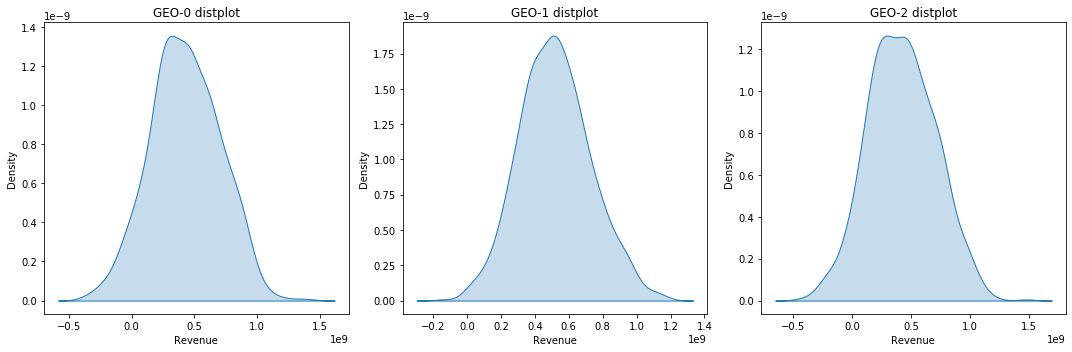

In [29]:
state = np.random.RandomState(12345)
bootstrap_samples = 1000
fig, axes = plt.subplots(1, 3, figsize=(15,5))

for axi, geo in enumerate([geo_0_res, geo_1_res, geo_2_res]):
    region = geo['name']
    target = geo['target']['product']
    predictions = geo['predictions']
    
    profit_values = [] # <----  мышь

    for i in range(bootstrap_samples):
        target_sample = target.sample(500, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]
        profit_values.append(get_profit_1(target_sample, predictions_sample))
    
    revenue = pd.Series(profit_values)
    
    mean_revenue = revenue.mean()
    confidence_interval = (revenue.quantile(0.025), revenue.quantile(0.975))
    risk = ((revenue < 0).mean() * 100)
    
    print(region)
    print(f"RMSE: {geo['rmse']}")
    print(f"Mean product: {geo['mean']}")
    print(f"Mean revenue: {mean_revenue}")
    print(f"Interval:     {confidence_interval}")
    print(f"Risk:         {risk}%")
    print()
    
    ax = axes[axi]
    sns.kdeplot(revenue, shade=True, ax=ax);
    ax.title.set_text(f'{region} distplot')
    ax.set_ylabel('Density')
    ax.set_xlabel('Revenue')
    
fig.tight_layout()
plt.show() 

# Вывод

Выяснено, что *наиболее перспективным районом для разработки является* ***GEO-1***, так как с вероятностью 95% средняя прибыль от добычи нефти в 200 скважинах будет от ~128 до ~583 млн. рублей, а риск убыточности лишь 0.3%. Другие районы также можно рассматривать для разработки, но согласно прогнозу, они менее прибыльные и риск убыточности ~6%.